# 2021 Western Canada Record Breaking Heat Wave

This notebook compares the all-time maximum temperature measured prior to the June/July 2021 western Canada heat-wave for all active (i.e. recording data as of June 25 2021) Environment Canada stations in British Columbia and Alberta that contain at least 15 years of data. 

### Import Dependencies

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap

### Load Active Environment Canada Weather Station Metadata
Environment Canada active weather stations, as of June 25 2021, with at least 15 years of daily records for BC and AB. 

In [3]:
# load active station metadata to dataframe
df = pd.read_csv('data/active_env_can_wx_stations.csv', parse_dates=['dly_date_first', 'dly_date_last'])
df.head()

,station_id,province,dly_date_first,dly_date_last,dly_years_active
0,32232,AB,2002-11-01,2021-07-05,19.0
1,374,BC,1978-01-01,2021-07-04,43.0
2,707,BC,1889-10-01,2021-06-29,132.0
3,706,BC,1988-11-01,2021-07-05,33.0
4,32253,AB,2002-12-01,2021-07-05,19.0


### Download All-Time Maximum Temperature Records
For each active station in BC and AB get the all-time maximum temperature recorded in Environment Canada almanac data - this includes the heat-wave

In [4]:
# empty dataframe to concatenate maximum temperature results
df_maximum_temperature_records = pd.DataFrame()

# for each active station, download almanac data, if available, and get maximum temperature recorded
print('Downloading Almanac Data')
for idx, row in df.iterrows():
    
    # url pointing to csv file of daily all-time record weather data for each active station
    base_url = 'https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={}&timeframe=4&submit=Download+Data'
    
    # create complete url by adding station id of current active station
    url_to_download = base_url.format(row.station_id)
    
    # dataframe of daily all-time record weather data for each active station
    df_wx = pd.read_csv(url_to_download)

    # if almanac data exists for maximum temperature then record the value
    try:
        # dataframe row corresponding to maximum temperature value
        df_temporary = pd.DataFrame(df_wx.loc[df_wx['Highest Temp. (°C)'].idxmax()]).T

        # add station id to temporary dataframe
        df_temporary['Station ID'] = row.station_id
        
        # create and add date column
        df_temporary['Max Temperature Date'] = [pd.to_datetime(str(year)+str(month)+str(day), format='%Y%m%d') 
                                                for year, month, day in 
                                                zip(df_temporary['Highest Temp.Year'], df_temporary.Month, df_temporary.Day)]
        
        # keep only columns relating to temperature
        df_temporary = df_temporary[['Station ID', 'Station Name', 'Longitude (x)', 'Latitude (y)',
                                     'Max Temperature Date', 'Highest Temp. (°C)']]
        
        # add temporary dataframe to storage
        df_maximum_temperature_records = pd.concat([df_maximum_temperature_records, df_temporary]) 
    except:
        print('No Historical Data For Station {}'.format(row.station_id))

# remove missing temperature records
df_maximum_temperature_records.dropna(subset=['Highest Temp. (°C)'], inplace=True)

# merge active station metadata table
df_maximum_temperature_records = df_maximum_temperature_records.merge(df, left_on='Station ID', right_on='station_id')
df_maximum_temperature_records.drop(columns=['station_id'], inplace=True)

# export maximum temperature records to csv for data retention
df_maximum_temperature_records.to_csv('data/all_time_high_temperatures_BC_AB.csv', index=None)

No Historical Data For Station 46867
No Historical Data For Station 1935
No Historical Data For Station 833
No Historical Data For Station 189
No Historical Data For Station 76
No Historical Data For Station 323
No Historical Data For Station 853
No Historical Data For Station 27018


### Plot Map of All-Time Maximum Temperature

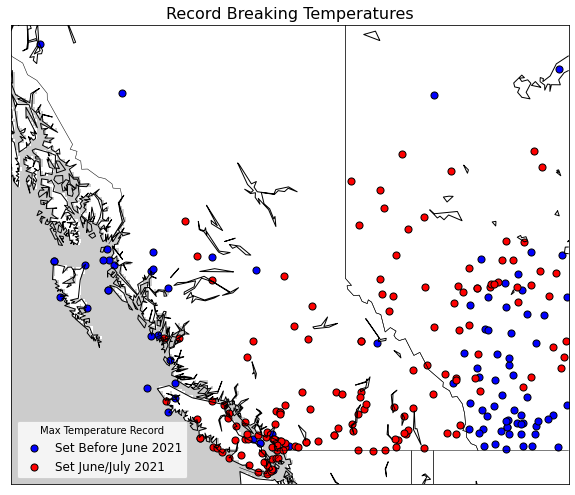

In [20]:
# dataframe of before heat wave records
df_before_heat_wave = df_maximum_temperature_records[df_maximum_temperature_records['Max Temperature Date'] < '2021-06-25']

# dataframe of new records set in heat wave - June 25 2021 onwards
df_heat_wave = df_maximum_temperature_records[df_maximum_temperature_records['Max Temperature Date'] >= '2021-06-25']

# basemap for plotting
m = Basemap(projection = "merc", resolution = "l",area_thresh = 100,
               llcrnrlon = -135, llcrnrlat = 48, urcrnrlon = -110, urcrnrlat = 60)
 
# figure and axes
fig, ax = plt.subplots(figsize=(10,10))
 
# create map boundaries and render
m.drawcoastlines()
m.drawlsmask(land_color='white', ocean_color='0.8', lakes=False)
m.drawcountries()
m.drawstates()

# transformed coordinates for before heat wave records
x1, y1 = m(df_before_heat_wave['Longitude (x)'], df_before_heat_wave['Latitude (y)'])

# transformed coordinates for heat wave records
x2, y2 = m(df_heat_wave['Longitude (x)'], df_heat_wave['Latitude (y)'])

# scatter plot of lat/lon for before and heat wave data
plt.scatter(x1, y1, s=50, edgecolors='k', facecolors='b',label='Set Before June 2021')
plt.scatter(x2, y2, s=50, edgecolors='k', facecolors='r', label='Set June/July 2021') 

# create title and legend
ax.set_title('Record Breaking Temperatures', fontsize=16)
plt.legend(fontsize=12, title='Max Temperature Record')

plt.savefig('record-breaking-temperature-map.png', dpi=600, bbox_inches='tight')

### Frequency Plot of Station Record Length and When Records Were Broken


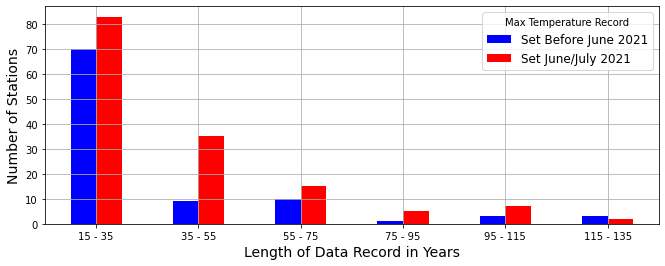

In [21]:
# counts of before heat wave records binned in 20 years
counts_before_heat_wave = pd.cut(df_before_heat_wave.dly_years_active, bins=np.linspace(15, 135, 7))
counts_index = counts_before_heat_wave.value_counts(sort=False).index
counts_before_heat_wave = counts_before_heat_wave.value_counts(sort=False).values

# counts of during heat wave records binned in 20 years
counts_heat_wave = pd.cut(df_heat_wave.dly_years_active, bins=np.linspace(15, 135, 7))
counts_heat_wave = counts_heat_wave.value_counts(sort=False).values

# combined counts dataframe
df = pd.DataFrame([counts_before_heat_wave, counts_heat_wave]).T
df.columns = ['Set Before June 2021', 'Set June/July 2021']

# bar plot of counts data
df.plot.bar(figsize=(11,4), color=['b','r']);

# relabel axis and set labels
plt.xticks([0, 1, 2, 3, 4, 5], ['15 - 35','35 - 55','55 - 75','75 - 95','95 - 115','115 - 135'], rotation='horizontal');
plt.ylabel('Number of Stations', fontsize=14)
plt.xlabel('Length of Data Record in Years', fontsize=14)
plt.legend(title='Max Temperature Record', fontsize=12)
plt.grid()

plt.savefig('record-breaking-temperature-frequency-plot.png', dpi=600, bbox_inches='tight')